In [4]:
import torch
print(torch.cuda.is_available())

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
import time



ImportError: Failed to load PyTorch C extensions:
    It appears that PyTorch has loaded the `torch/_C` folder
    of the PyTorch repository rather than the C extensions which
    are expected in the `torch._C` namespace. This can occur when
    using the `install` workflow. e.g.
        $ python setup.py install && python -c "import torch"

    This error can generally be solved using the `develop` workflow
        $ python setup.py develop && python -c "import torch"  # This should succeed
    or by running Python from a different directory.

In [3]:
df = pd.read_csv('dataset.csv')
df.head()

NameError: name 'pd' is not defined

In [4]:
numerical_features = [
    "Application order","Age at enrollment", "Curricular units 1st sem (credited)", "Curricular units 1st sem (enrolled)",
    "Curricular units 1st sem (evaluations)","Curricular units 1st sem (approved)","Curricular units 1st sem (grade)",
    "Curricular units 1st sem (without evaluations)","Curricular units 2nd sem (credited)","Curricular units 2nd sem (enrolled)",
    "Curricular units 2nd sem (evaluations)","Curricular units 2nd sem (approved)",
    "Curricular units 2nd sem (without evaluations)","Unemployment rate","Inflation rate","GDP","Curricular units 2nd sem (grade)"
]
categorical_features = [
    "Marital status","Application mode","Course","Daytime/evening attendance","Previous qualification","Nationality",
    "Mother's qualification","Father's qualification","Mother's occupation","Father's occupation","Displaced",
    "Educational special needs","Debtor","Tuition fees up to date","Gender","Scholarship holder","International"
]


In [5]:
X = df.drop(['Target'],axis=1)
y = LabelEncoder().fit_transform(df['Target'])

preprocessor = ColumnTransformer([
    ('num',StandardScaler(),numerical_features),
    ('cat',OneHotEncoder(handle_unknown='ignore',sparse_output=False),categorical_features)
])

X_train, X_test, y_train, y_test = train_test_split(X,y,train_size =0.8,random_state=42)

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)



In [6]:
X_train_processed.shape, X_test_processed.shape, y_train.shape

((3539, 247), (885, 247), (3539,))

In [7]:
class_num = len(np.unique(y_train))
class_num

3

In [8]:
X_train_tensor = torch.tensor(X_train_processed,dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_processed,dtype=torch.float32)
y_train_tensor = torch.tensor(y_train,dtype=torch.torch.long)
y_test_tensor = torch.tensor(y_test,dtype=torch.long)



In [9]:
class MultiClassModel(nn.Module):
  def __init__(self,input_features_size,classes_num):
    super(MultiClassModel,self).__init__()
    self.linear = nn.Linear(input_features_size,classes_num)

  def forward(self, x):
      logits = self.linear(x)
      return logits




In [10]:
input_size = X_train_processed.shape[1]
classes_num = len(np.unique(y_train))

In [11]:
clf = MultiClassModel(input_size,classes_num)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
clf = clf.to(device)


optimizer = torch.optim.Adam(clf.parameters(),lr=0.001)
X_train_tensor = X_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

In [12]:
# model training
def fit(X,y,n_iters=2000,batch_size=64):
  errors = []
  dataset = TensorDataset(X,y)
  loader = DataLoader(dataset,batch_size=batch_size,shuffle=True)
  for i in range(n_iters):
    for X_batch, y_batch in loader:
      optimizer.zero_grad()
      logits = clf(X_batch)
      loss = F.cross_entropy(logits,y_batch)
      loss.backward()
      optimizer.step()
    with torch.no_grad():
      full_logits = clf(X)
      full_loss = F.cross_entropy(full_logits,y)
      errors.append(full_loss.item())

    if i % 100 == 0:
      print(f"Iter {i}, Loss: {loss:.4f}")
  plt.plot(np.arange(len(errors)), errors)
  plt.show()

def accuracy(X, y):
    with torch.inference_mode():
        logits = clf(X)
        _, predicted = torch.max(logits, dim=1)
        acc = (predicted == y).sum().item() / len(y)
        print(f'Accuracy: {acc * 100:.2f}%')


Iter 0, Loss: 0.9730
Iter 100, Loss: 0.4962
Iter 200, Loss: 0.4084
Iter 300, Loss: 0.4967
Iter 400, Loss: 0.4798
Iter 500, Loss: 0.4834
Iter 600, Loss: 0.4677
Iter 700, Loss: 0.5107
Iter 800, Loss: 0.4448
Iter 900, Loss: 0.4237
Iter 1000, Loss: 0.4579
Iter 1100, Loss: 0.4834
Iter 1200, Loss: 0.4944
Iter 1300, Loss: 0.4505
Iter 1400, Loss: 0.4830
Iter 1500, Loss: 0.4663
Iter 1600, Loss: 0.3946
Iter 1700, Loss: 0.4885
Iter 1800, Loss: 0.4125
Iter 1900, Loss: 0.4673


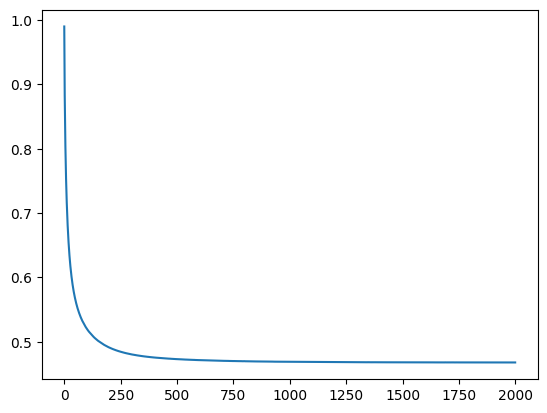

106.66918158531189


In [13]:
start_time = time.time()
fit(X_train_tensor,y_train_tensor)
end_time = time.time()
elapsed_time = end_time - start_time
print(elapsed_time)

In [66]:
accuracy(X_test_tensor,y_test_tensor)

Accuracy: 75.48%


In [67]:
accuracy(X_train_tensor,y_train_tensor)


Accuracy: 81.80%


Accuracy: 75,48% (test_case)


Accuracy: 81.80% (train_case)



Without CUDA T4:
Time:106s

With CUDA T4: Time:89s